In [1]:
# Viz
import hvplot.xarray
import numpy as np
import odc.stac
import pandas as pd
import planetary_computer
import pyproj
import pystac_client
import xarray as xr
from dask.distributed import Client
from pystac.extensions.eo import EOExtension as eo

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

bbox = [-118.89, 38.54, -118.57, 38.84]  # Region over a lake in Nevada, USA
datetime = "2017-06-01/2017-09-30"  # Summer months of 2017
collection = "landsat-c2-l2"
platform = "landsat-8"
cloudy_less_than = 1  # percent

search = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=bbox,
    datetime=datetime,
    query={"eo:cloud_cover": {"lt": cloudy_less_than}, "platform": {"in": [platform]}},
)
items = search.item_collection()
print(f"Returned {len(items)} Items:")
[[i, item.id] for i, item in enumerate(items)]

Returned 3 Items:


[[0, 'LC08_L2SP_042033_20170718_02_T1'],
 [1, 'LC08_L2SP_042033_20170702_02_T1'],
 [2, 'LC08_L2SP_042033_20170616_02_T1']]

In [3]:
item = items[1]  # select one of the results

In [4]:
# TODO: show the pre-rendered thumbnail

In [5]:
assets = []
for _, asset in item.assets.items():
    try:
        assets.append(asset.extra_fields["eo:bands"][0])
    except:
        pass

cols_ordered = [
    "common_name",
    "description",
    "name",
    "center_wavelength",
    "full_width_half_max",
]
bands = pd.DataFrame.from_dict(assets)[cols_ordered]
bands

,common_name,description,name,center_wavelength,full_width_half_max
0,red,Visible red,OLI_B4,0.65,0.04
1,blue,Visible blue,OLI_B2,0.48,0.06
2,green,Visible green,OLI_B3,0.56,0.06
3,nir08,Near infrared,OLI_B5,0.87,0.03
4,lwir11,Long-wave infrared,TIRS_B10,10.90,0.59
5,swir16,Short-wave infrared,OLI_B6,1.61,0.09
6,swir22,Short-wave infrared,OLI_B7,2.20,0.19
7,coastal,Coastal/Aerosol,OLI_B1,0.44,0.02


In [6]:
ds_2017 = odc.stac.stac_load(
    [item],
    bands=bands.common_name.values,
    bbox=bbox,
    chunks={},  # <-- use Dask
    resolution=100,
).isel(time=0)

In [7]:
epsg = item.properties["proj:code"]
ds_2017.attrs["crs"] = f"epsg:{epsg}"

In [8]:
da_2017 = ds_2017.to_array(dim="band")
da_2017

<xarray.DataArray (band: 8, y: 339, x: 285)> Size: 2MB
dask.array<stack, shape=(8, 339, 285), dtype=uint16, chunksize=(1, 339, 285), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) object 64B 'red' 'blue' 'green' ... 'swir22' 'coastal'
  * y            (y) float64 3kB 4.301e+06 4.301e+06 ... 4.267e+06 4.267e+06
  * x            (x) float64 2kB 3.353e+05 3.354e+05 ... 3.636e+05 3.637e+05
    spatial_ref  int32 4B 32611
    time         datetime64[ns] 8B 2017-07-02T18:33:06.200763
Attributes:
    crs:      epsg:EPSG:32611

In [9]:
# TODO: add histograms of values in each band

Why do we have to flatten the data?

In [10]:
flattened_xda = da_2017.stack(z=("x", "y"))  # flatten each band
flattened_t_xda = flattened_xda.transpose("z", "band")
flattened_t_xda

<xarray.DataArray (z: 96615, band: 8)> Size: 2MB
dask.array<transpose, shape=(96615, 8), dtype=uint16, chunksize=(96615, 1), chunktype=numpy.ndarray>
Coordinates:
  * z            (z) object 773kB MultiIndex
  * band         (band) object 64B 'red' 'blue' 'green' ... 'swir22' 'coastal'
    spatial_ref  int32 4B 32611
    time         datetime64[ns] 8B 2017-07-02T18:33:06.200763
  * x            (z) float64 773kB 3.353e+05 3.353e+05 ... 3.637e+05 3.637e+05
  * y            (z) float64 773kB 4.301e+06 4.301e+06 ... 4.267e+06 4.267e+06
Attributes:
    crs:      epsg:EPSG:32611

Why do we have to rescale for k-means? How will this be different for, e.g., RF models?

In [11]:
with xr.set_options(keep_attrs=True):
    rescaled_xda = (flattened_t_xda - flattened_t_xda.mean()) / flattened_t_xda.std()
rescaled_xda

<xarray.DataArray (z: 96615, band: 8)> Size: 6MB
dask.array<truediv, shape=(96615, 8), dtype=float64, chunksize=(96615, 1), chunktype=numpy.ndarray>
Coordinates:
  * z            (z) object 773kB MultiIndex
  * band         (band) object 64B 'red' 'blue' 'green' ... 'swir22' 'coastal'
    spatial_ref  int32 4B 32611
    time         datetime64[ns] 8B 2017-07-02T18:33:06.200763
  * x            (z) float64 773kB 3.353e+05 3.353e+05 ... 3.637e+05 3.637e+05
  * y            (z) float64 773kB 4.301e+06 4.301e+06 ... 4.267e+06 4.267e+06
Attributes:
    crs:      epsg:EPSG:32611

In [12]:
print(rescaled_xda)

<xarray.DataArray (z: 96615, band: 8)> Size: 6MB
dask.array<truediv, shape=(96615, 8), dtype=float64, chunksize=(96615, 1), chunktype=numpy.ndarray>
Coordinates:
  * z            (z) object 773kB MultiIndex
  * band         (band) object 64B 'red' 'blue' 'green' ... 'swir22' 'coastal'
    spatial_ref  int32 4B 32611
    time         datetime64[ns] 8B 2017-07-02T18:33:06.200763
  * x            (z) float64 773kB 3.353e+05 3.353e+05 ... 3.637e+05 3.637e+05
  * y            (z) float64 773kB 4.301e+06 4.301e+06 ... 4.267e+06 4.267e+06
Attributes:
    crs:      epsg:EPSG:32611


In [13]:
client = Client(processes=False)
client

/home/nissim/Documents/dev/musa-650-spring-2026/.venv/lib/python3.11/site-packages/distributed/node.py:188: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34217 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://10.2.0.2:34217/status,
Dashboard: http://10.2.0.2:34217/status,Workers: 1
Total threads: 16,Total memory: 54.73 GiB
Status: running,Using processes: False
Comm: inproc://10.2.0.2/124505/1,Workers: 0
Dashboard: http://10.2.0.2:34217/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: inproc://10.2.0.2/124505/4,Total threads: 16
Dashboard: http://10.2.0.2:34007/status,Memory: 54.73 GiB
Nanny: None,


In [14]:
X = client.persist(rescaled_xda)
X.shape

(96615, 8)

In [ ]:
from dask_ml.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=0, max_iter=100)
kmeans.fit(X)
labels = kmeans.labels_.compute()
labels.shape

(96615,)

In [30]:
labels

array([0, 0, 0, ..., 0, 0, 0], shape=(96615,), dtype=int32)

In [31]:
template = flattened_t_xda[:, 0]
output_array = template.copy(data=labels)
output_array

<xarray.DataArray (z: 96615)> Size: 386kB
array([0, 0, 0, ..., 0, 0, 0], shape=(96615,), dtype=int32)
Coordinates:
  * z            (z) object 773kB MultiIndex
    spatial_ref  int32 4B 32611
    time         datetime64[ns] 8B 2017-07-02T18:33:06.200763
    band         <U3 12B 'red'
  * x            (z) float64 773kB 3.353e+05 3.353e+05 ... 3.637e+05 3.637e+05
  * y            (z) float64 773kB 4.301e+06 4.301e+06 ... 4.267e+06 4.267e+06
Attributes:
    crs:      epsg:EPSG:32611

In [32]:
unstacked_2017 = output_array.unstack()
unstacked_2017

<xarray.DataArray (x: 285, y: 339)> Size: 386kB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(285, 339), dtype=int32)
Coordinates:
  * x            (x) float64 2kB 3.353e+05 3.354e+05 ... 3.636e+05 3.637e+05
  * y            (y) float64 3kB 4.301e+06 4.301e+06 ... 4.267e+06 4.267e+06
    spatial_ref  int32 4B 32611
    time         datetime64[ns] 8B 2017-07-02T18:33:06.200763
    band         <U3 12B 'red'
Attributes:
    crs:      epsg:EPSG:32611

In [33]:
# Check the labels
print("Unique labels:", np.unique(labels))
print("Label counts:", np.bincount(labels))
print("Label dtype:", labels.dtype)
print("Label shape:", labels.shape)

Unique labels: [0 1]
Label counts: [82962 13653]
Label dtype: int32
Label shape: (96615,)


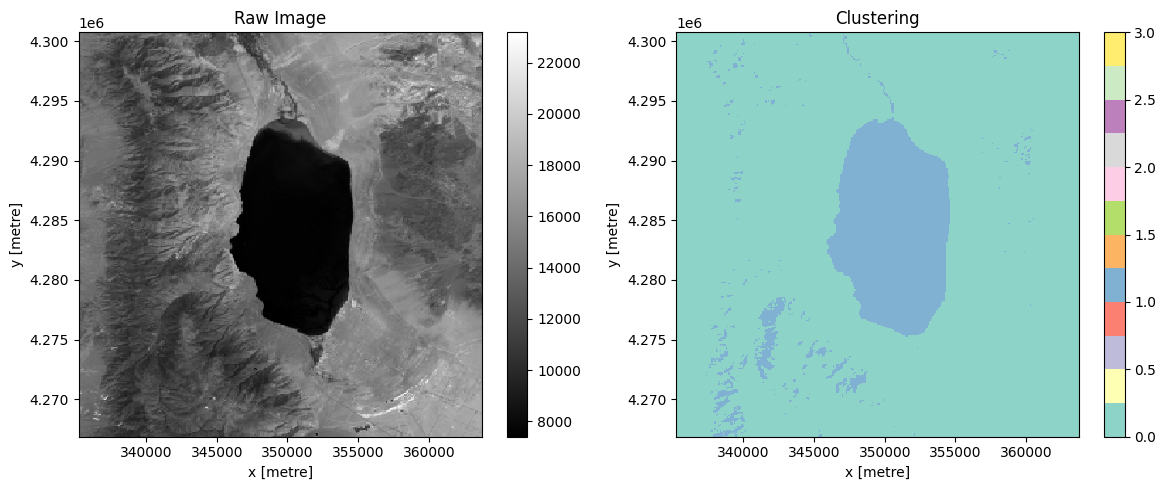

In [34]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot raw
da_2017.sel(band="red").plot(ax=ax1, cmap="gray")
ax1.set_title("Raw Image")

# Plot clustering - transpose if needed
unstacked_2017.T.plot(ax=ax2, cmap="Set3", vmin=0, vmax=3)  # Add .T to transpose
ax2.set_title("Clustering")

plt.tight_layout()
plt.show()

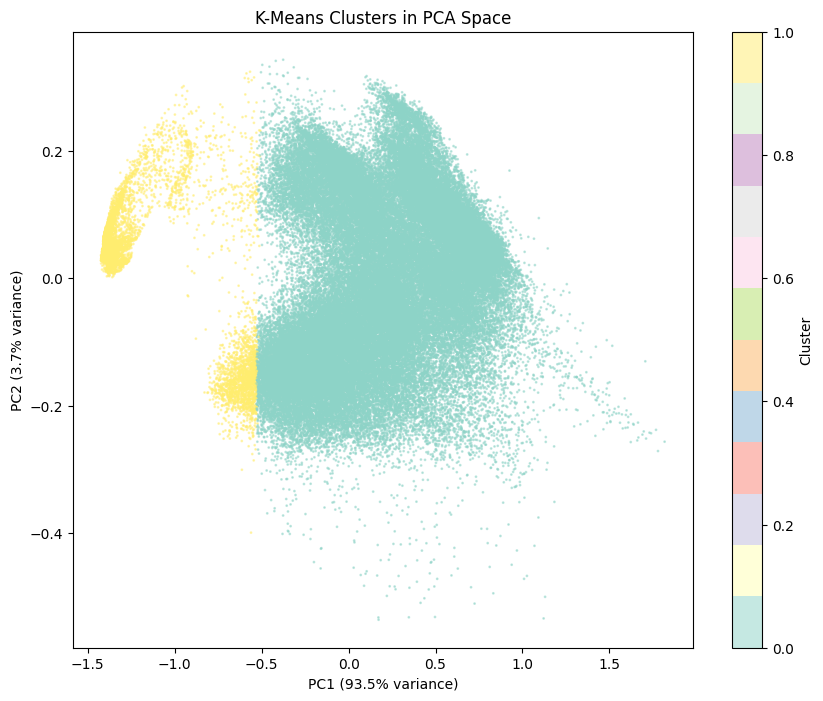

In [35]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Get the computed data
X_computed = X.compute()

# Reduce to 2D with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_computed)

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap="Set3", alpha=0.5, s=1)
plt.colorbar(scatter, label="Cluster")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
plt.title("K-Means Clusters in PCA Space")
plt.show()

PCA Loadings:
              PC1       PC2
red      0.349057  0.229995
blue     0.208231  0.248302
green    0.270363  0.256362
nir08    0.422149 -0.455608
swir16   0.329540  0.613160
swir22   0.496535 -0.428911
lwir11   0.443156 -0.081700
coastal  0.178779  0.213409


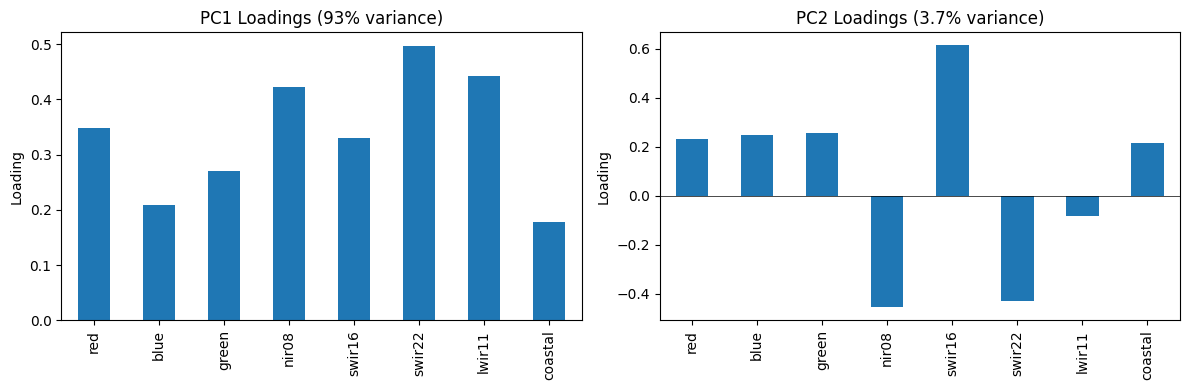

In [36]:
# See which bands contribute most to PC1
loadings = pd.DataFrame(
    pca.components_.T,
    columns=["PC1", "PC2"],
    index=["red", "blue", "green", "nir08", "swir16", "swir22", "lwir11", "coastal"],
)
print("PCA Loadings:")
print(loadings)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
loadings["PC1"].plot(kind="bar", ax=ax1, title="PC1 Loadings (93% variance)")
ax1.set_ylabel("Loading")
ax1.axhline(y=0, color="k", linestyle="-", linewidth=0.5)

loadings["PC2"].plot(
    kind="bar",
    ax=ax2,
    title=f"PC2 Loadings ({pca.explained_variance_ratio_[1]:.1%} variance)",
)
ax2.set_ylabel("Loading")
ax2.axhline(y=0, color="k", linestyle="-", linewidth=0.5)
plt.tight_layout()
plt.show()

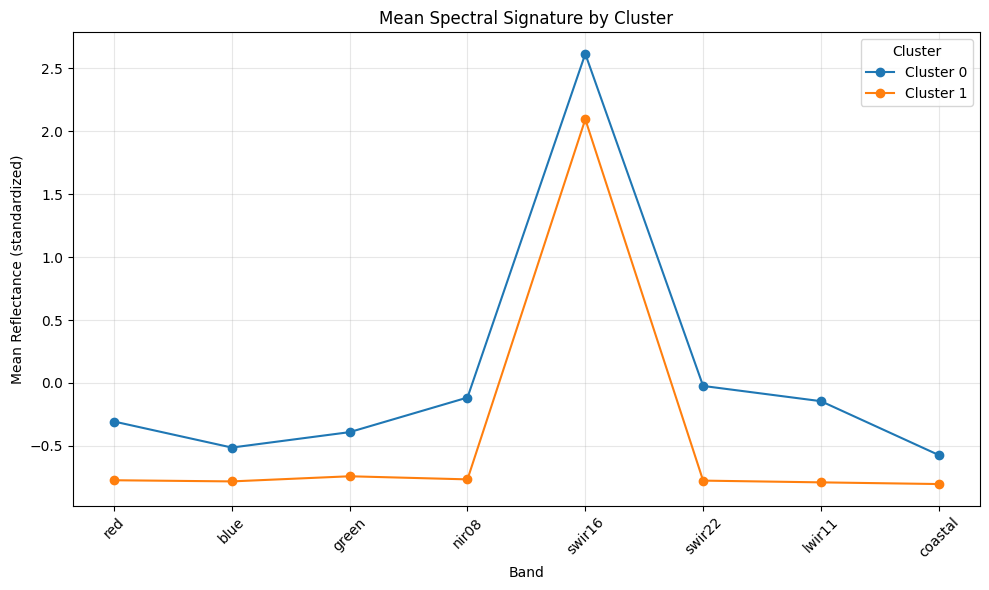

In [37]:
# Create dataframe
cluster_means = pd.DataFrame(
    X_computed,
    columns=["red", "blue", "green", "nir08", "swir16", "swir22", "lwir11", "coastal"],
)
cluster_means["cluster"] = labels

# Get means per cluster
means_by_cluster = cluster_means.groupby("cluster").mean()

# Plot spectral signatures
means_by_cluster.T.plot(figsize=(10, 6), marker="o")
plt.xlabel("Band")
plt.ylabel("Mean Reflectance (standardized)")
plt.title("Mean Spectral Signature by Cluster")
plt.legend(title="Cluster", labels=[f"Cluster {i}" for i in range(4)])
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

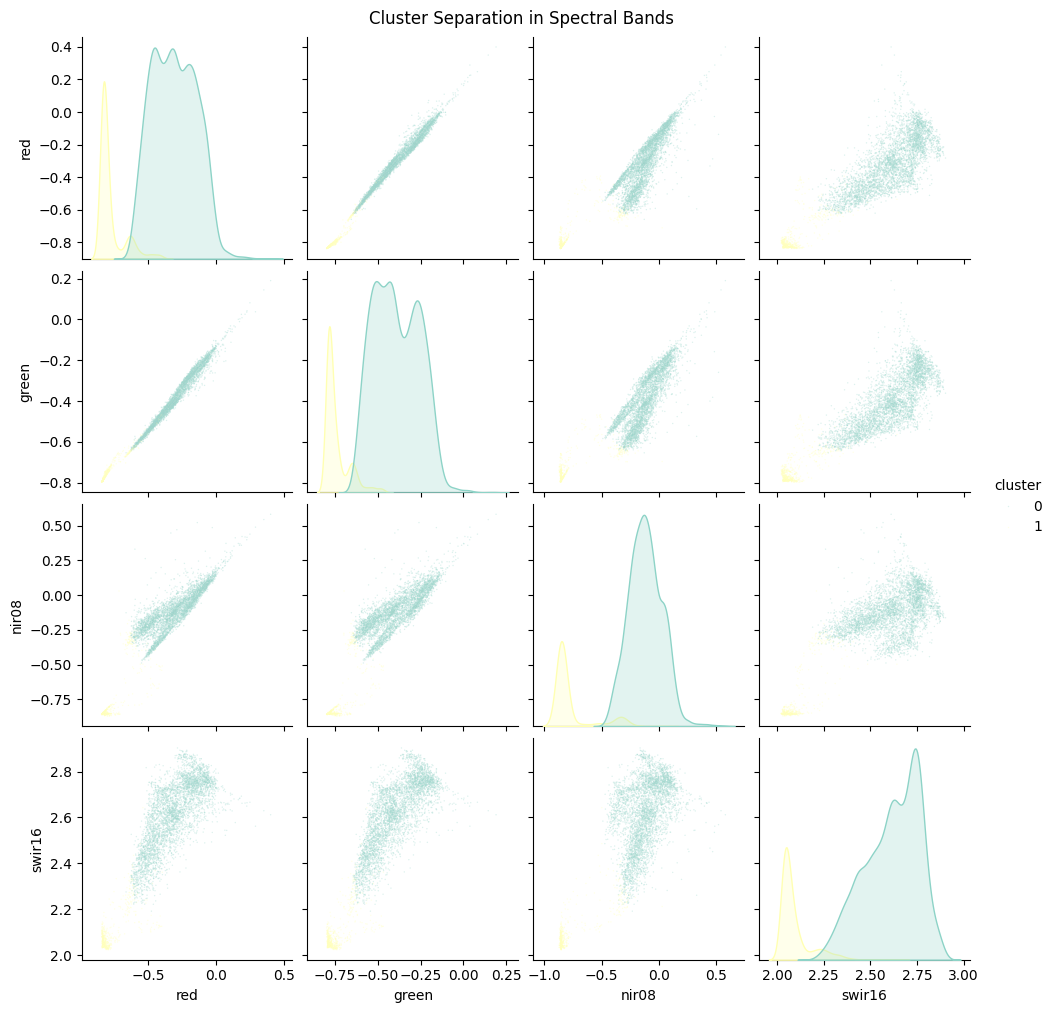

In [38]:
import pandas as pd
import seaborn as sns

# Create dataframe with subset of data (sample for speed)
sample_idx = np.random.choice(len(labels), size=5000, replace=False)
df = pd.DataFrame(
    X_computed[sample_idx],
    columns=["red", "blue", "green", "nir08", "swir16", "swir22", "lwir11", "coastal"],
)
df["cluster"] = labels[sample_idx]

# Pairplot (pick a few key bands to avoid too many plots)
sns.pairplot(
    df[["red", "green", "nir08", "swir16", "cluster"]],
    hue="cluster",
    palette="Set3",
    plot_kws={"alpha": 0.3, "s": 1},
)
plt.suptitle("Cluster Separation in Spectral Bands", y=1.01)
plt.show()

### 1998

In [40]:
bbox = [-118.89, 38.54, -118.57, 38.84]  # Region over a lake in Nevada, USA
datetime = "1988-06-01/1988-09-30"  # Summer months of 1988
collection = "landsat-c2-l2"
platform = "landsat-5"  # Searching through an earlier landsat mission
cloudy_less_than = 1  # percent

search = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=bbox,
    datetime=datetime,
    query={"eo:cloud_cover": {"lt": cloudy_less_than}, "platform": {"in": [platform]}},
)

items = search.get_all_items()
item = items[1]  # select one of the results

/home/nissim/Documents/dev/musa-650-spring-2026/.venv/lib/python3.11/site-packages/pystac_client/item_search.py:940: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


In [41]:
assets = []
for _, asset in item.assets.items():
    try:
        assets.append(asset.extra_fields["eo:bands"][0])
    except:
        pass

cols_ordered = [
    "common_name",
    "description",
    "name",
    "center_wavelength",
    "full_width_half_max",
]
bands = pd.DataFrame.from_dict(assets)[cols_ordered]
bands

,common_name,description,name,center_wavelength,full_width_half_max
0,red,Visible red,TM_B3,0.66,0.06
1,blue,Visible blue,TM_B1,0.49,0.07
2,lwir,Long-wave infrared,TM_B6,11.45,2.10
3,green,Visible green,TM_B2,0.56,0.08
4,nir08,Near infrared,TM_B4,0.83,0.14
5,swir16,Short-wave infrared,TM_B5,1.65,0.20
6,swir22,Short-wave infrared,TM_B7,2.22,0.27


In [43]:
ds_1988 = odc.stac.stac_load(
    [item],
    bands=bands.common_name.values,
    bbox=bbox,
    chunks={},  # <-- use Dask
).isel(time=0)

epsg = item.properties["proj:code"]
ds_1988.attrs["crs"] = f"epsg:{epsg}"

da_1988 = ds_1988.to_array(dim="band")
da_1988

<xarray.DataArray (band: 7, y: 1128, x: 950)> Size: 15MB
dask.array<stack, shape=(7, 1128, 950), dtype=uint16, chunksize=(1, 1128, 950), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) object 56B 'red' 'blue' 'lwir' ... 'swir16' 'swir22'
  * y            (y) float64 9kB 4.301e+06 4.301e+06 ... 4.267e+06 4.267e+06
  * x            (x) float64 8kB 3.353e+05 3.353e+05 ... 3.637e+05 3.638e+05
    spatial_ref  int32 4B 32611
    time         datetime64[ns] 8B 1988-07-02T18:03:59.010013
Attributes:
    crs:      epsg:EPSG:32611

In [44]:
flattened_xda = da_1988.stack(z=("x", "y"))
flattened_t_xda = flattened_xda.transpose("z", "band")
with xr.set_options(keep_attrs=True):
    rescaled_xda = (flattened_t_xda - flattened_t_xda.mean()) / flattened_t_xda.std()
rescaled_xda

<xarray.DataArray (z: 1071600, band: 7)> Size: 60MB
dask.array<truediv, shape=(1071600, 7), dtype=float64, chunksize=(1071600, 1), chunktype=numpy.ndarray>
Coordinates:
  * z            (z) object 9MB MultiIndex
  * band         (band) object 56B 'red' 'blue' 'lwir' ... 'swir16' 'swir22'
    spatial_ref  int32 4B 32611
    time         datetime64[ns] 8B 1988-07-02T18:03:59.010013
  * x            (z) float64 9MB 3.353e+05 3.353e+05 ... 3.638e+05 3.638e+05
  * y            (z) float64 9MB 4.301e+06 4.301e+06 ... 4.267e+06 4.267e+06
Attributes:
    crs:      epsg:EPSG:32611

In [ ]:
X = client.persist(rescaled_xda)

kmeans = KMeans(n_clusters=4, random_state=0, max_iter=100)
kmeans.fit(X)
labels = kmeans.labels_.compute()
labels.shape

/home/nissim/Documents/dev/musa-650-spring-2026/.venv/lib/python3.11/site-packages/distributed/client.py:3374: UserWarning: Sending large graph of size 57.24 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/home/nissim/Documents/dev/musa-650-spring-2026/.venv/lib/python3.11/site-packages/distributed/client.py:3374: UserWarning: Sending large graph of size 57.23 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/home/nissim/Documents/dev/musa-650-spring-2026/.venv/lib/python3.11/site-packages/distributed/client.py

CPU times: user 31.3 s, sys: 2.22 s, total: 33.5 s
Wall time: 9.35 s


/home/nissim/Documents/dev/musa-650-spring-2026/.venv/lib/python3.11/site-packages/distributed/client.py:3374: UserWarning: Sending large graph of size 57.24 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/home/nissim/Documents/dev/musa-650-spring-2026/.venv/lib/python3.11/site-packages/distributed/client.py:3374: UserWarning: Sending large graph of size 57.24 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


(1071600,)

In [47]:
template = flattened_t_xda[:, 0]
output_array = template.copy(data=labels)
unstacked_1988 = output_array.unstack()

In [48]:
unstacked_1988

<xarray.DataArray (x: 950, y: 1128)> Size: 4MB
array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]], shape=(950, 1128), dtype=int32)
Coordinates:
  * x            (x) float64 8kB 3.353e+05 3.353e+05 ... 3.637e+05 3.638e+05
  * y            (y) float64 9kB 4.301e+06 4.301e+06 ... 4.267e+06 4.267e+06
    spatial_ref  int32 4B 32611
    time         datetime64[ns] 8B 1988-07-02T18:03:59.010013
    band         <U3 12B 'red'
Attributes:
    crs:      epsg:EPSG:32611

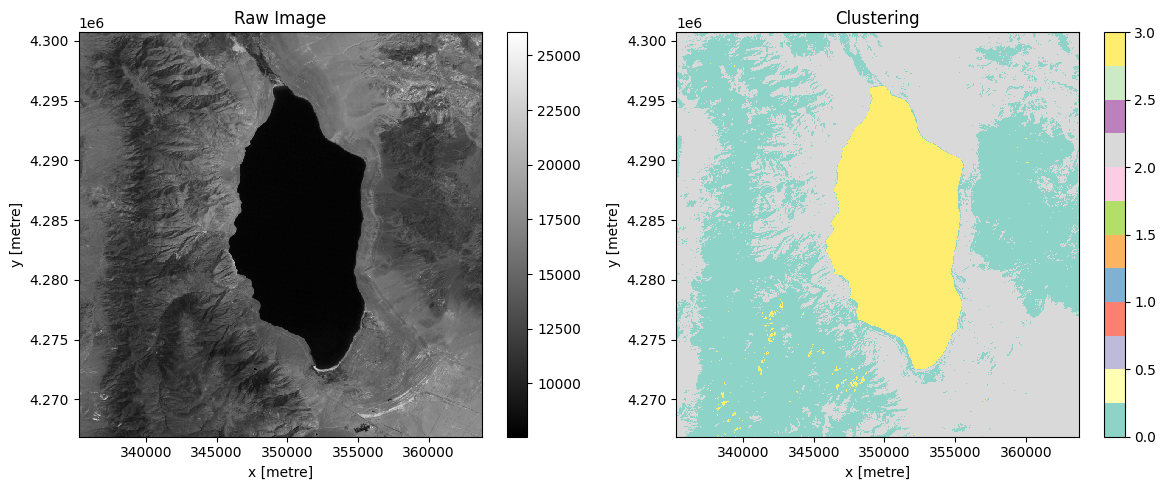

In [49]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot raw
da_1988.sel(band="red").plot(ax=ax1, cmap="gray")
ax1.set_title("Raw Image")

# Plot clustering - transpose if needed
unstacked_1988.T.plot(ax=ax2, cmap="Set3", vmin=0, vmax=3)  # Add .T to transpose
ax2.set_title("Clustering")

plt.tight_layout()
plt.show()

### Over Time

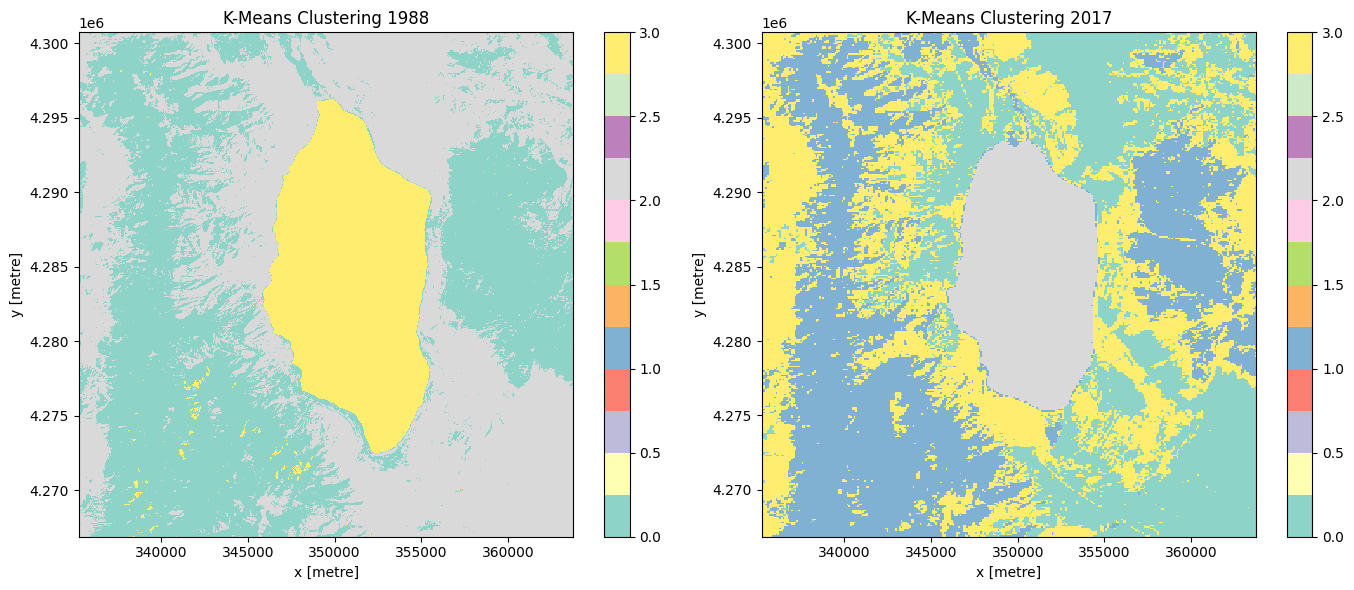

In [51]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

unstacked_1988.T.plot(ax=ax1, cmap="Set3", vmin=0, vmax=3)
ax1.set_title("K-Means Clustering 1988")

unstacked_2017.T.plot(ax=ax2, cmap="Set3", vmin=0, vmax=3)
ax2.set_title("K-Means Clustering 2017")

plt.tight_layout()
plt.show()

water cluster values: 3 2


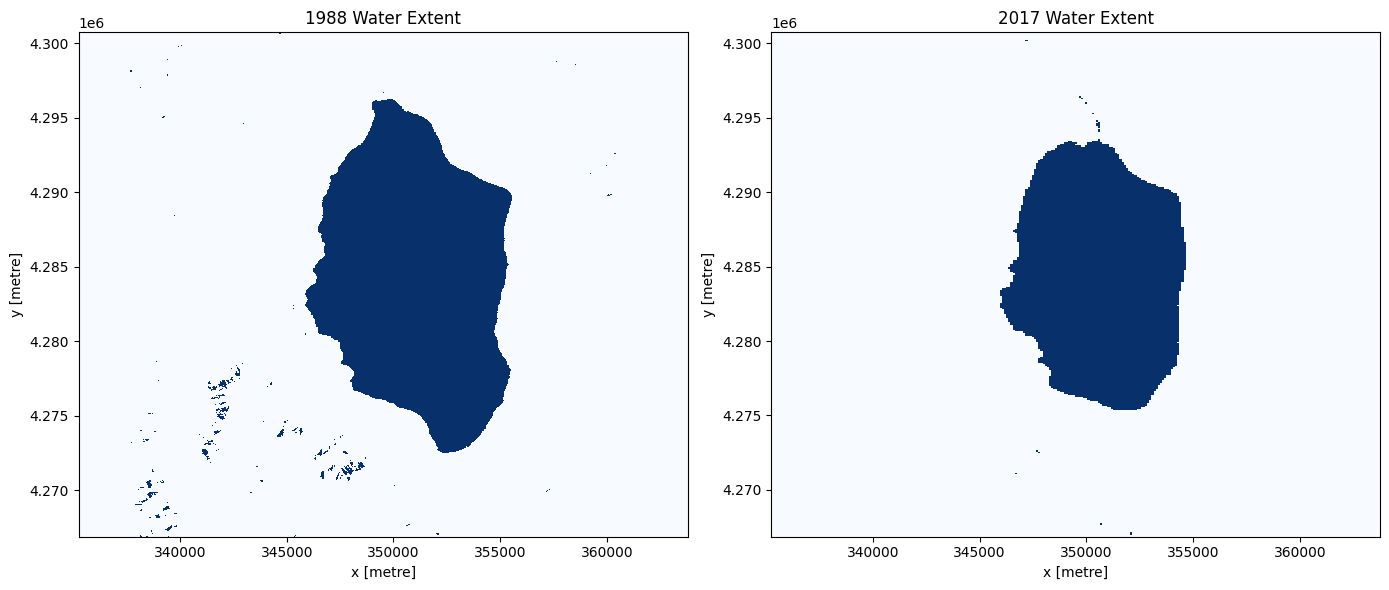

In [54]:
lon_lake_center = -118.71
lat_lake_center = 38.7

# Fix the CRS string - remove double prefix
crs_string = str(unstacked_1988.crs).replace("epsg:EPSG:", "EPSG:")
proj = pyproj.Proj(crs_string)
lake_center_x, lake_center_y = proj(lon_lake_center, lat_lake_center)

water_cluster_1988 = int(
    unstacked_1988.sel(x=lake_center_x, y=lake_center_y, method="nearest")
)
water_cluster_2017 = int(
    unstacked_2017.sel(x=lake_center_x, y=lake_center_y, method="nearest")
)

print("water cluster values:", water_cluster_1988, water_cluster_2017)

# Create water masks
with xr.set_options(keep_attrs=True):
    water_1988 = (unstacked_1988 == water_cluster_1988).astype(int)
    water_2017 = (unstacked_2017 == water_cluster_2017).astype(int)

# Plot with matplotlib
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

water_1988.T.plot(ax=ax1, cmap="Blues", vmin=0, vmax=1, add_colorbar=False)
ax1.set_title("1988 Water Extent")

water_2017.T.plot(ax=ax2, cmap="Blues", vmin=0, vmax=1, add_colorbar=False)
ax2.set_title("2017 Water Extent")

plt.tight_layout()
plt.show()

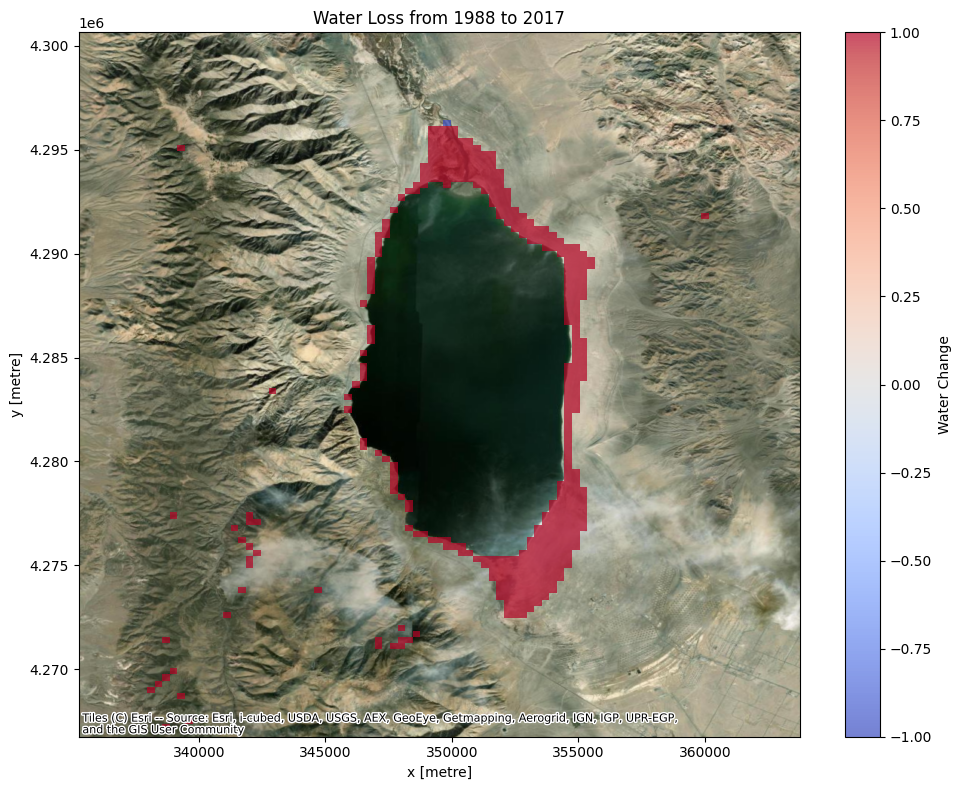

In [58]:
import contextily as cx

fig, ax = plt.subplots(figsize=(10, 8))

water_diff_masked.T.plot(
    ax=ax,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    alpha=0.7,
    cbar_kwargs={"label": "Water Change"},
)

# Add basemap
cx.add_basemap(ax, crs=crs_string, source=cx.providers.Esri.WorldImagery)

ax.set_title("Water Loss from 1988 to 2017")
plt.tight_layout()
plt.show()